In [ ]:
! unzip DryBeanDataset.zip

Archive:  DryBeanDataset.zip
   creating: DryBeanDataset/
  inflating: DryBeanDataset/Dry_Bean_Dataset.arff  
  inflating: DryBeanDataset/Dry_Bean_Dataset.txt  
  inflating: DryBeanDataset/Dry_Bean_Dataset.xlsx  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from pandas_profiling import ProfileReport

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report, plot_confusion_matrix, accuracy_score, silhouette_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
import xgboost as xgb

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px



%matplotlib inline 

In [ ]:
df = pd.read_excel("/content/DryBeanDataset/Dry_Bean_Dataset.xlsx")
df[['Class']] = df[['Class']].apply(lambda col:pd.Categorical(col).codes)

In [ ]:
df.head()

Area  Perimeter  MajorAxisLength  ...  ShapeFactor3  ShapeFactor4  Class
0  28395    610.291       208.178117  ...      0.834222      0.998724      5
1  28734    638.018       200.524796  ...      0.909851      0.998430      5
2  29380    624.110       212.826130  ...      0.825871      0.999066      5
3  30008    645.884       210.557999  ...      0.861794      0.994199      5
4  30140    620.134       201.847882  ...      0.941900      0.999166      5

[5 rows x 17 columns]

In [ ]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Created wheel for pandas-profiling: filename=pandas_profiling-2.12.0-py2.py3-none-any.whl size=243829 sha256=31d11e34f98f06abd6f95b807dfbeffa9a692a548d134ad5d4e5be2e99822797
  Stored in directory: /tmp/pip-ephem-wheel-cache-13ts65u9/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
Successfully built pandas-profiling


In [ ]:
profile = ProfileReport(df, explorative=True, title='Dry Bean Exploratory Analysis')
profile

In [ ]:
profile.to_file(output_file="Dry_Beans.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df.isnull().sum().sum()

0

In [ ]:
X = df.drop(["Class"], axis=1)
Y = df["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state = 0)

## Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(max_depth=6, n_estimators=10, random_state=1)
rf.fit(X_train, y_train)  
y_pred = rf.predict(X_test)

In [ ]:
accuracy_score(y_pred, y_test)

0.9114946749908189

## Importance Comparison between features

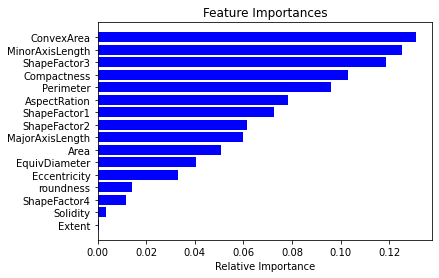

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Visualizing the data

### Seaborn Pairplot

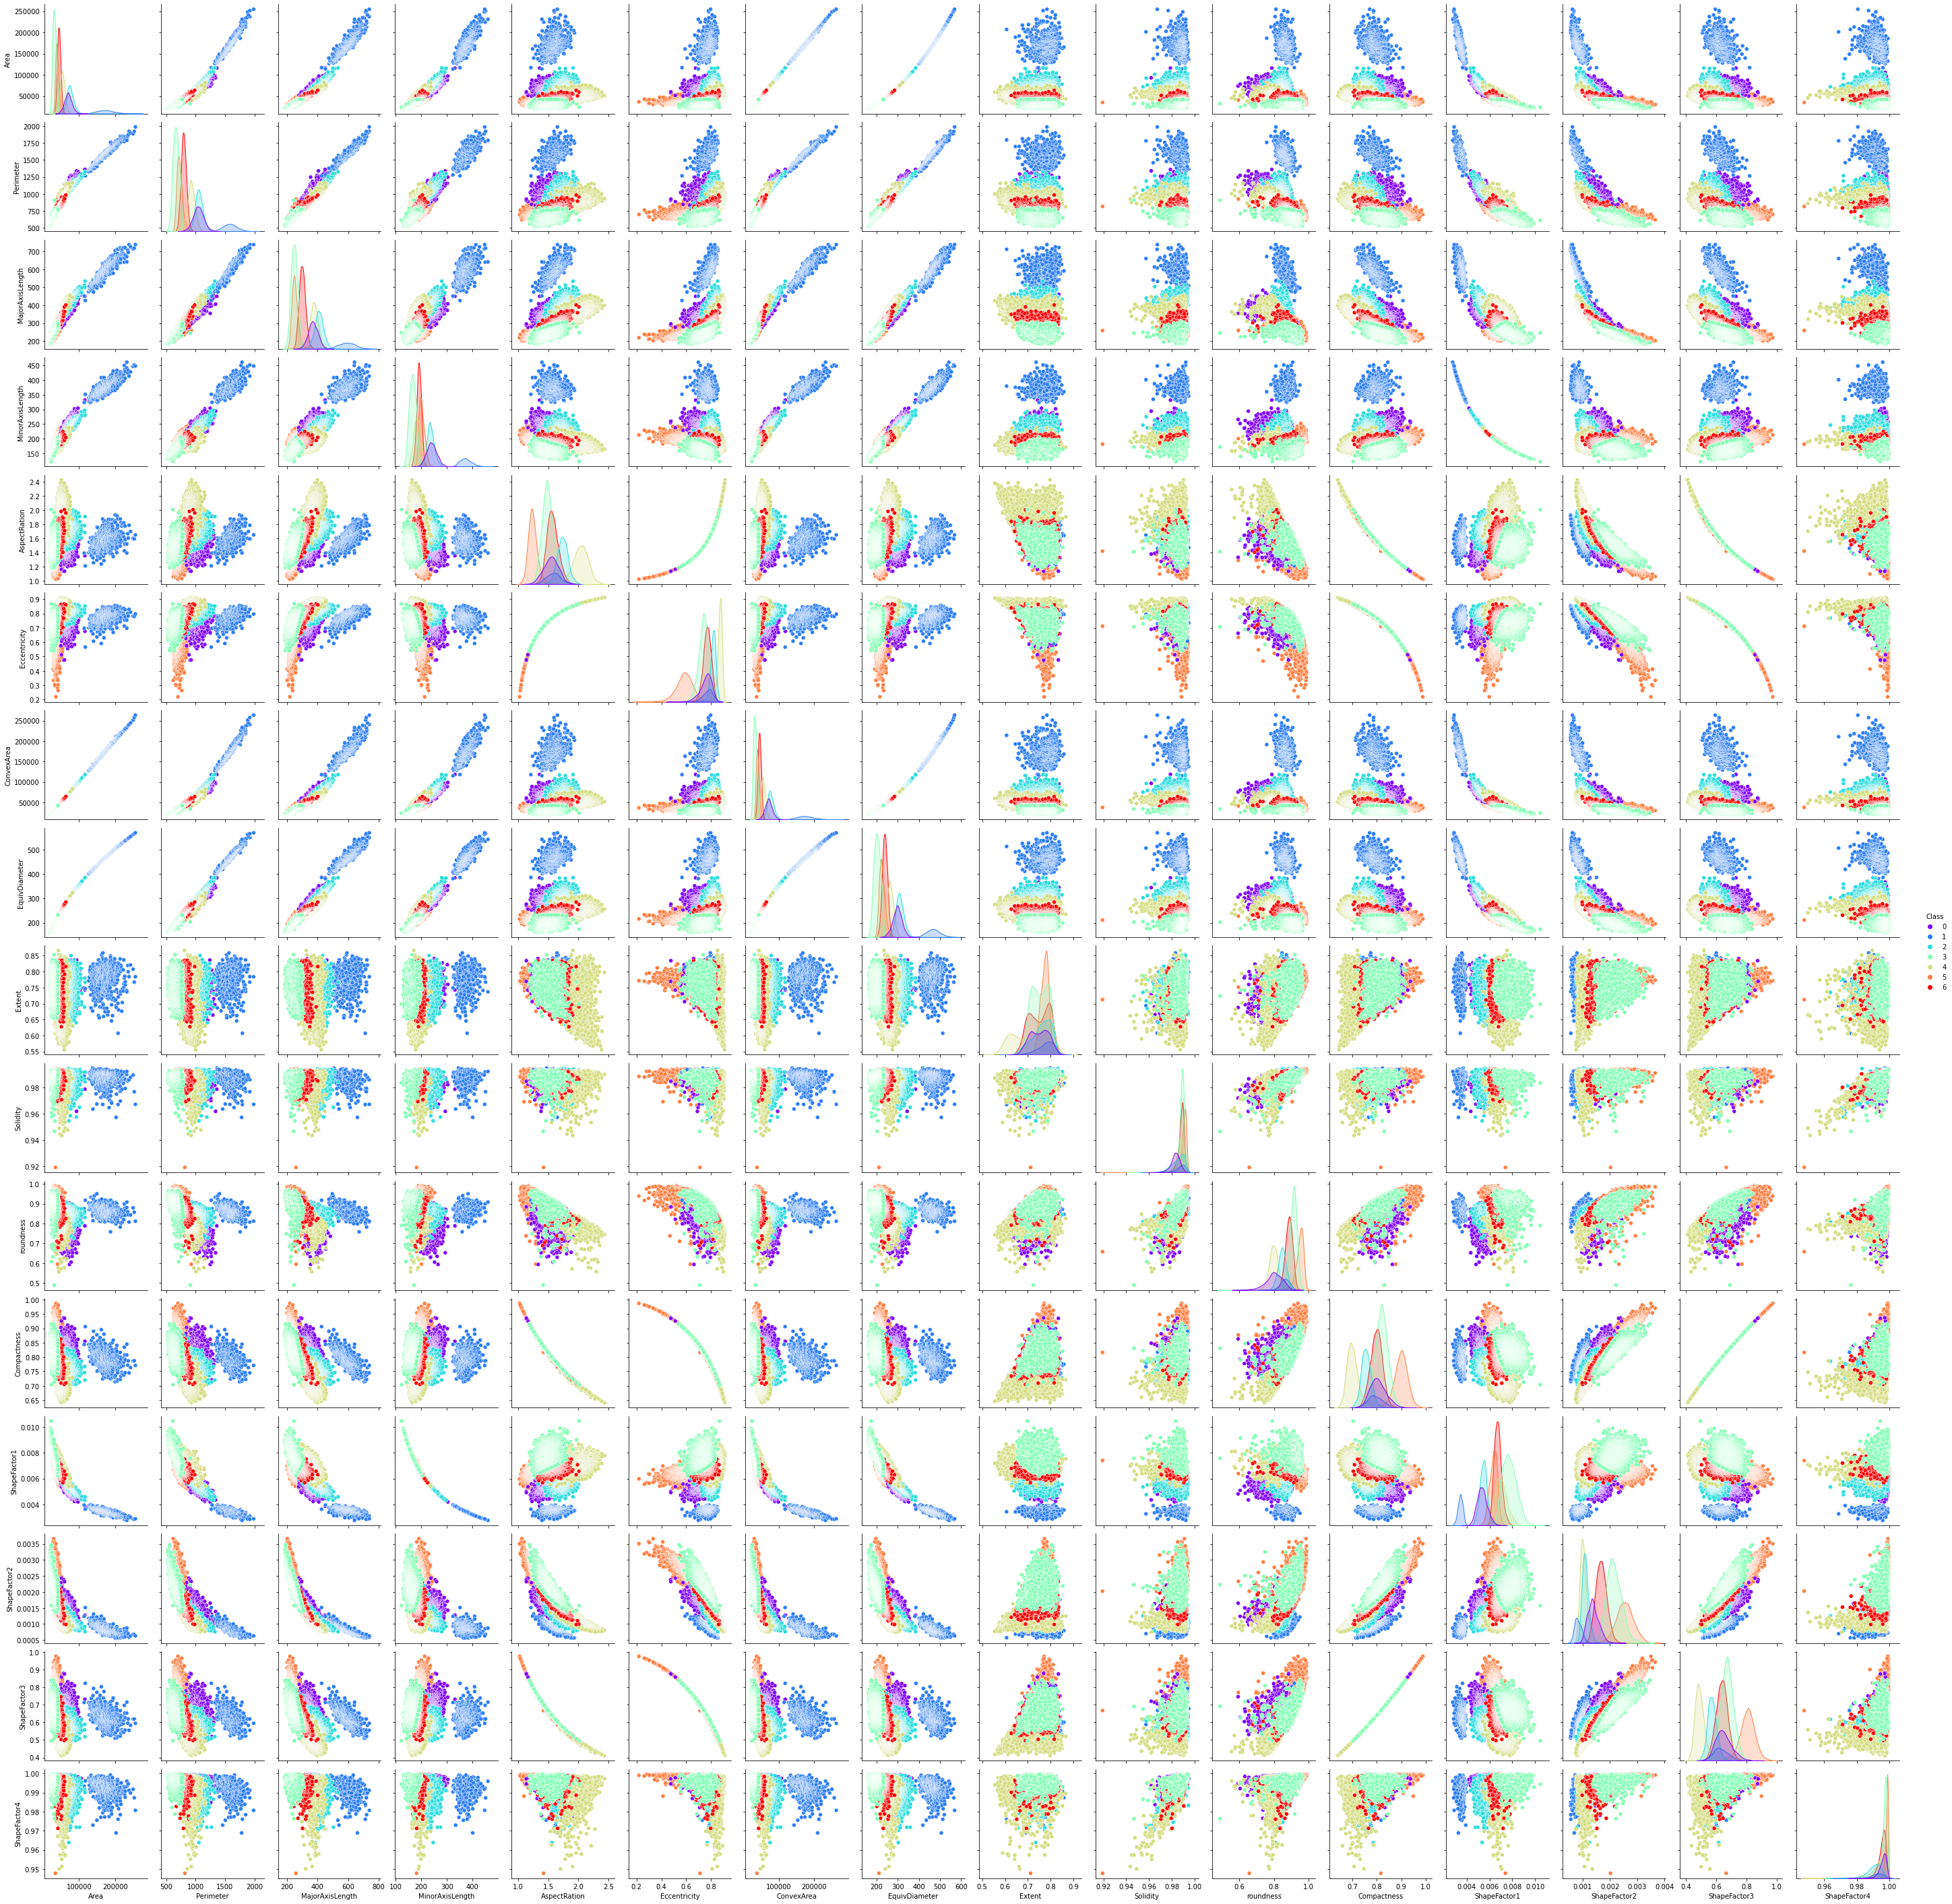

In [ ]:
## Zoom in to visualize pairwise relations
## Uncomment the following line to generate
#  sns.pairplot(data=df, hue="Class", palette="rainbow")

In [ ]:
df.corr()

Area  Perimeter  ...  ShapeFactor4     Class
Area             1.000000   0.966722  ...     -0.355721 -0.475252
Perimeter        0.966722   1.000000  ...     -0.429310 -0.507638
MajorAxisLength  0.931834   0.977338  ...     -0.482527 -0.455175
MinorAxisLength  0.951602   0.913179  ...     -0.263749 -0.458492
AspectRation     0.241735   0.385276  ...     -0.449264 -0.116332
Eccentricity     0.267481   0.391066  ...     -0.449354 -0.200356
ConvexArea       0.999939   0.967689  ...     -0.362049 -0.477459
EquivDiameter    0.984968   0.991380  ...     -0.392512 -0.481099
Extent           0.054345  -0.021160  ...      0.148502 -0.031184
Solidity        -0.196585  -0.303970  ...      0.702163  0.321283
roundness       -0.357530  -0.547647  ...      0.472149  0.384972
Compactness     -0.268067  -0.406857  ...      0.484436  0.156204
ShapeFactor1    -0.847958  -0.864623  ...      0.248619  0.391907
ShapeFactor2    -0.639291  -0.767592  ...      0.529932  0.335122
ShapeFactor3    -0.272145  -0.408435  ...      0.484274  0.167673
ShapeFactor4    -0.355721  -0.429310  ...      1.000000  0.165033
Class           -0.475252  -0.507638  ...      0.165033  1.000000

[17 rows x 17 columns]

### Pairwise Correlation

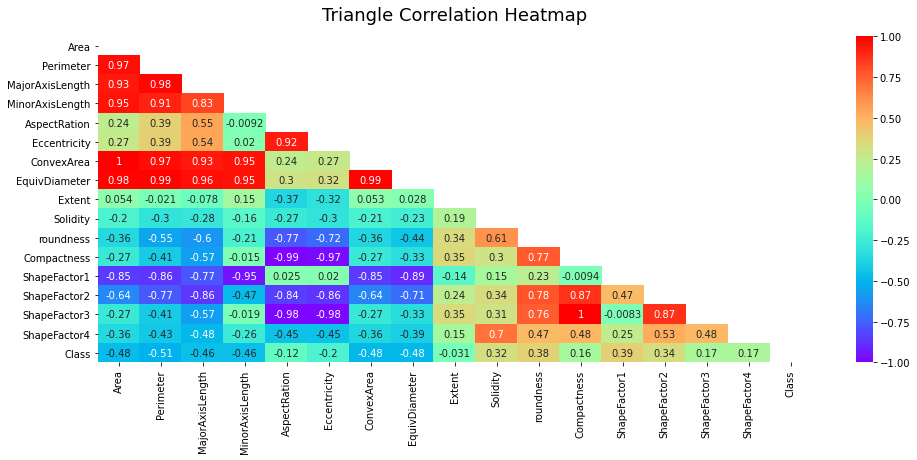

In [ ]:
np.triu(np.ones_like(df.corr()))
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='rainbow')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

## Let's look at the most correlated pairs:
* Perimeter -> Area
* MajorAxisLength -> Area
* MinorAxisLength -> Area
* Eccentricity -> AspectRation
* ConvexArea -> Area
* EquivDiameter -> Area
* Compactness -> AspectRation
* ShapeFactor1 -> MinorAxisLength
* ShapeFactor3 -> AspectRation


### Pairplots among most correlated features

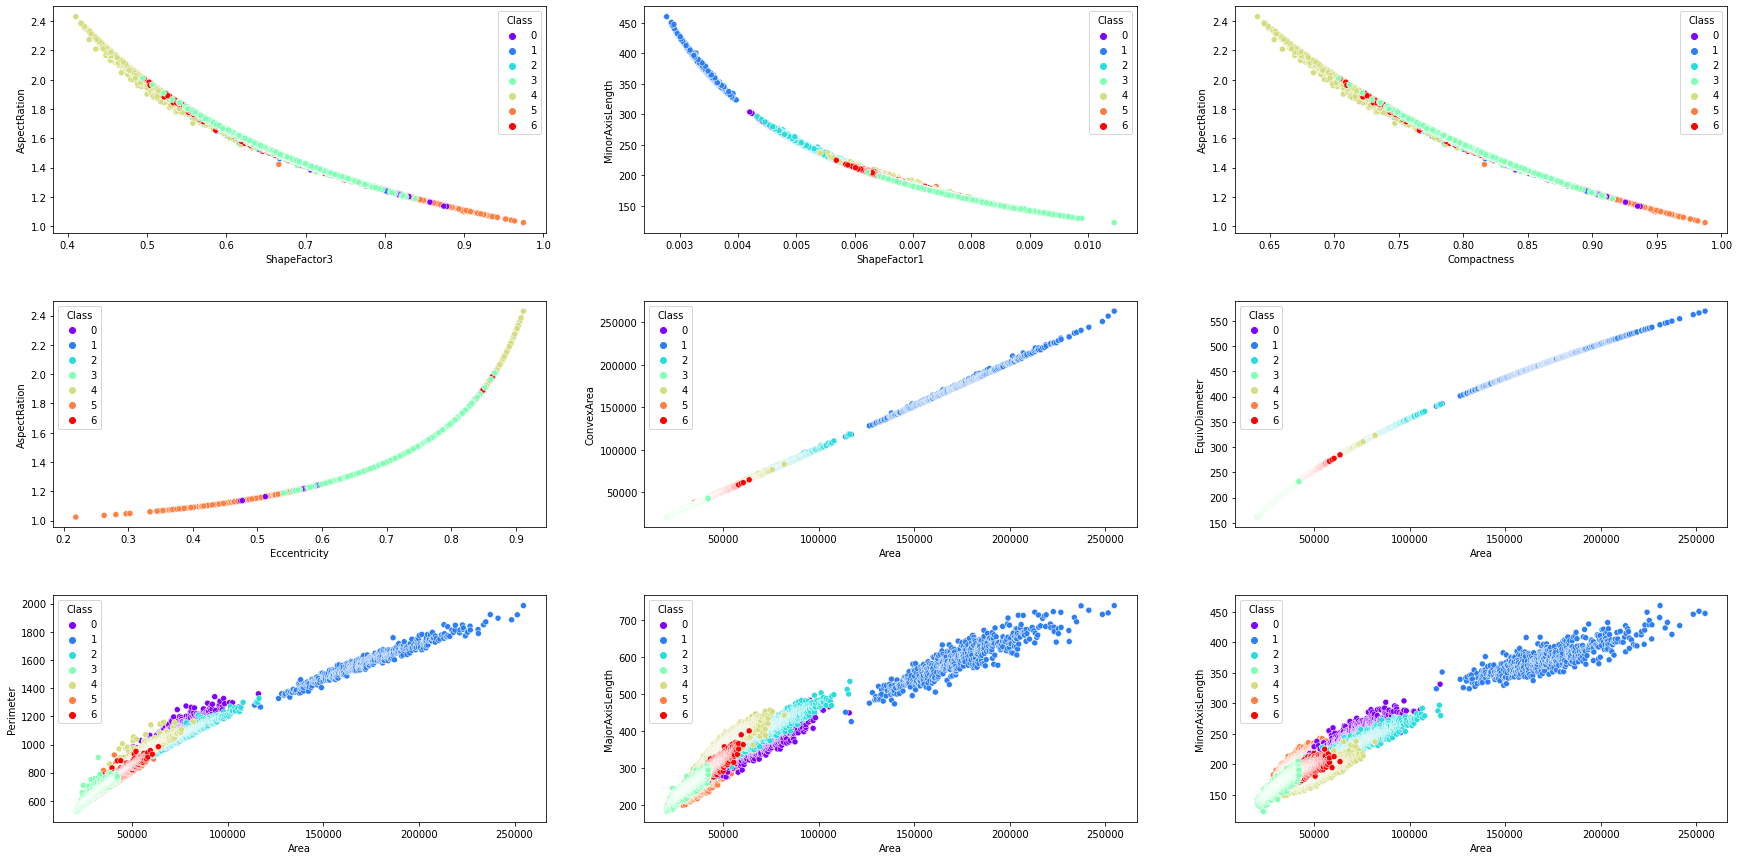

In [ ]:
fig = plt.figure(figsize=(30,15))
fig.subplots_adjust(hspace=0.3, wspace=0.2)
ax = fig.add_subplot(3, 3, 1)
sns.scatterplot(x=df.ShapeFactor3, y=df.AspectRation, hue=df.Class, ax=ax, palette="rainbow")
ax = fig.add_subplot(3, 3, 2)
sns.scatterplot(x=df.ShapeFactor1, y=df.MinorAxisLength, hue=df.Class, ax=ax, palette="rainbow")
ax = fig.add_subplot(3, 3, 3)
sns.scatterplot(x=df.Compactness, y=df.AspectRation, hue=df.Class, ax=ax, palette="rainbow")
ax = fig.add_subplot(3, 3, 4)
sns.scatterplot(x=df.Eccentricity, y=df.AspectRation, hue=df.Class, ax=ax, palette="rainbow")
ax = fig.add_subplot(3, 3, 5)
sns.scatterplot(x=df.Area, y=df.ConvexArea, hue=df.Class, ax=ax, palette="rainbow")
ax = fig.add_subplot(3, 3, 6)
sns.scatterplot(x=df.Area, y=df.EquivDiameter, hue=df.Class, ax=ax, palette="rainbow")
ax = fig.add_subplot(3, 3, 7)

sns.scatterplot(x=df.Area, y=df.Perimeter, hue=df.Class, ax=ax, palette="rainbow")
ax = fig.add_subplot(3, 3, 8)

sns.scatterplot(x=df.Area, y=df.MajorAxisLength, hue=df.Class, ax=ax, palette="rainbow")
ax = fig.add_subplot(3, 3, 9)

sns.scatterplot(x=df.Area, y=df.MinorAxisLength, hue=df.Class, ax=ax, palette="rainbow")

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



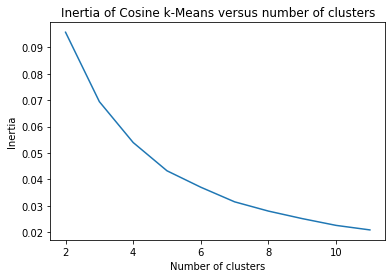

In [ ]:
normalized_vectors = preprocessing.normalize(df)
scores = [KMeans(n_clusters=i+2).fit(normalized_vectors).inertia_ for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of Cosine k-Means versus number of clusters");

In [ ]:
normalized_kmeans = KMeans(n_clusters=7)
normalized_kmeans.fit(normalized_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### Reducing dimensions and plotting

In [ ]:
def plot_3d(df, name='labels'):
    iris = px.data.iris()
    fig = px.scatter_3d(df, x='1', y='2', z='3',
                  color=name, opacity=0.5)
    fig.update_traces(marker=dict(size=3))
    fig.show()

In [ ]:
def prepare_pca(n_components, data, kmeans_labels):
    names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']
    matrix = PCA(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

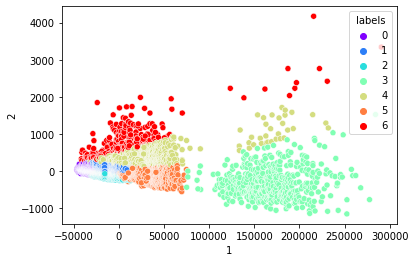

In [ ]:
pca_df = prepare_pca(2, df, normalized_kmeans.labels_)
sns.scatterplot(x=pca_df['1'], y=pca_df['2'], hue=pca_df.labels, palette="rainbow");

In [ ]:
pca_df = prepare_pca(3, df, normalized_kmeans.labels_)
plot_3d(pca_df)

In [ ]:
def prepare_tsne(n_components, data, kmeans_labels):
    names = ['1', '2', '3']
    matrix = TSNE(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    return df_matrix

In [ ]:
def plot_tsne(tnse_data, kmeans_labels):
    df_tsne = pd.DataFrame(tsne_data).rename({0: 'x', 1: 'y'}, axis=1)
    df_tsne['z'] = kmeans_labels
    sns.scatterplot(x=df_tsne.x, y=df_tsne.y, hue=df_tsne.z, palette="rainbow")
    plt.show()
    

In [ ]:
tsne_3d_df = prepare_tsne(3, df, normalized_kmeans.labels_)
plot_3d(tsne_3d_df)

In [ ]:
kmeans = KMeans(n_clusters=7).fit(df)
normalized_vectors = preprocessing.normalize(df)
normalized_kmeans = KMeans(n_clusters=7).fit(normalized_vectors)

In [ ]:
print('kmeans: {}'.format(silhouette_score(df, kmeans.labels_, metric='euclidean')))
print('Cosine kmeans: {}'.format(silhouette_score(normalized_vectors, normalized_kmeans.labels_, metric='cosine')))


kmeans: 0.5334798512868597
Cosine kmeans: 0.5321796847988681


### Dimension Reductionality

#### This was done to see if creating uncorrelated features out of the original dataframe improved the model accuracy. Since the dataset had only 16 features, therefore the result is not surprising

In [ ]:
for i in range(1, 16):
  pca_df = prepare_pca(i, df, normalized_kmeans.labels_)
  x = pca_df.drop(["labels"], axis=1)
  y = pca_df["labels"]
  x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)
  x_train_scaled = scaler.fit_transform(x_train)
  x_test_scaled = scaler.transform(x_test)
  clf = SVC(kernel='poly', degree=2) 
  clf.fit(x_train_scaled, y_train)
  y_pred = clf.predict(x_test_scaled)
  print(f'Accuracy for i = {i} is: {accuracy_score(y_test, y_pred)}')
  print(pca_df.head())

## Conclusion
Reducing dimension does not boost the model accuracy primarily because the number of features are already very low.

## Random Forest Classifier with Grid Search

In [ ]:
params_grid = [{'max_depth': [5,6,7,8,9,10],
                     'n_estimators': [10, 20, 50, 100]}]
rf = GridSearchCV(RandomForestClassifier(), params_grid, cv=5)

rf.fit(X_train, y_train)  
y_pred = rf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       255
           1       1.00      1.00      1.00        92
           2       0.93      0.94      0.94       350
           3       0.92      0.93      0.92       735
           4       0.95      0.94      0.95       390
           5       0.95      0.95      0.95       376
           6       0.85      0.87      0.86       525

    accuracy                           0.92      2723
   macro avg       0.94      0.93      0.93      2723
weighted avg       0.92      0.92      0.92      2723



### Standardizing the data

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### SVM with GridSearchCV

In [ ]:
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
               {'kernel': ['poly'], 'degree': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'C': [1, 10, 100, 1000]}]

In [ ]:
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000],
                          'degree': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'kernel': ['poly']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Degree:',svm_model.best_estimator_.degree,"\n")

final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test_scaled)


Best score for training data: 0.9273512255388899 

Best C: 1000 

Best Kernel: poly 

Best Degree: 2 



In [ ]:
print(confusion_matrix(y_test,Y_pred))
print("\n")
print(classification_report(y_test,Y_pred))

print("Training set score for SVM: %f" % final_model.score(X_train_scaled, y_train))
print("Testing  set score for SVM: %f" % final_model.score(X_test_scaled, y_test ))

svm_model.score

[[235   0  10   0   2   2   6]
 [  0  92   0   0   0   0   0]
 [  5   0 338   0   4   1   2]
 [  1   0   2 687   1   8  36]
 [  1   0   4   3 374   0   8]
 [  3   0   0   2   0 361  10]
 [  1   0   0  49   5   3 467]]


              precision    recall  f1-score   support

           0       0.96      0.92      0.94       255
           1       1.00      1.00      1.00        92
           2       0.95      0.97      0.96       350
           3       0.93      0.93      0.93       735
           4       0.97      0.96      0.96       390
           5       0.96      0.96      0.96       376
           6       0.88      0.89      0.89       525

    accuracy                           0.94      2723
   macro avg       0.95      0.95      0.95      2723
weighted avg       0.94      0.94      0.94      2723

Training set score for SVM: 0.936627
Testing  set score for SVM: 0.937936


<bound method BaseSearchCV.score of GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000],
                          'degree': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'kernel': ['poly']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)>

## XGBoosting

In [ ]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
xgb_model.fit(X_train_scaled, y_train)

y_pred = xgb_model.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))

[[228   0  17   0   2   2   6]
 [  0  92   0   0   0   0   0]
 [  4   0 338   0   5   1   2]
 [  0   0   0 686   2  12  35]
 [  2   0   5   2 369   0  12]
 [  0   0   0   2   0 360  14]
 [  1   0   2  54   5   3 460]]


In [ ]:
from scipy.stats import uniform, randint
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), 
    "max_depth": randint(2, 6), 
    "n_estimators": randint(100, 150), 
    "subsample": uniform(0.6, 0.4)
}

In [ ]:
search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X_train_scaled, y_train)

y_pred = search.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 59.5min finished


              precision    recall  f1-score   support

           0       0.97      0.90      0.94       255
           1       1.00      1.00      1.00        92
           2       0.94      0.97      0.95       350
           3       0.93      0.93      0.93       735
           4       0.96      0.95      0.96       390
           5       0.96      0.96      0.96       376
           6       0.87      0.88      0.88       525

    accuracy                           0.93      2723
   macro avg       0.95      0.94      0.94      2723
weighted avg       0.93      0.93      0.93      2723



## Let's try a neural network

In [ ]:
from keras.utils import np_utils
train_y = np_utils.to_categorical(y_train)
test_y = np_utils.to_categorical(y_test)

In [ ]:
from  tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
input = Input(shape = (16))
layer1 = Dense(256, activation="relu")(input)
layer2 = Dense(256, activation="relu")(layer1)
layer3 = Dense(128, activation="relu")(layer2)
layer4 = Dense(64, activation="relu")(layer3)
layer5 = Dense(32, activation="relu")(layer4)
layer6 = Dense(32, activation="relu")(layer5)
layer7 = Dense(16, activation="relu")(layer6)
final_layer = Dense(7, activation="softmax")(layer4)
model = Model(inputs=input, outputs=final_layer)

In [ ]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=50,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False,
)


Epoch 1/100
341/341 [==============================] - 2s 4ms/step - loss: 0.4446 - accuracy: 0.8411 - val_loss: 0.2937 - val_accuracy: 0.9027
Epoch 2/100
341/341 [==============================] - 1s 4ms/step - loss: 0.2370 - accuracy: 0.9150 - val_loss: 0.2514 - val_accuracy: 0.9192
Epoch 3/100
341/341 [==============================] - 1s 4ms/step - loss: 0.2285 - accuracy: 0.9193 - val_loss: 0.2272 - val_accuracy: 0.9192
Epoch 4/100
341/341 [==============================] - 1s 4ms/step - loss: 0.2335 - accuracy: 0.9184 - val_loss: 0.1979 - val_accuracy: 0.9343
Epoch 5/100
341/341 [==============================] - 1s 4ms/step - loss: 0.2149 - accuracy: 0.9245 - val_loss: 0.2240 - val_accuracy: 0.9280
Epoch 6/100
341/341 [==============================] - 1s 4ms/step - loss: 0.2086 - accuracy: 0.9264 - val_loss: 0.2196 - val_accuracy: 0.9277
Epoch 7/100
341/341 [==============================] - 1s 4ms/step - loss: 0.2072 - accuracy: 0.9240 - val_loss: 0.2640 - val_accuracy: 0.9071

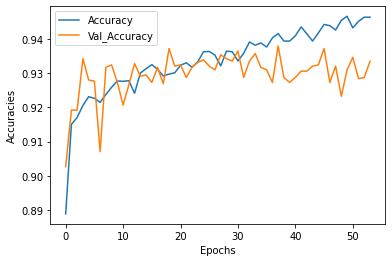

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.003), metrics=['accuracy'])
history = model.fit(X_train_scaled, train_y, epochs=100, batch_size=32,  validation_data=(X_test_scaled,test_y), callbacks=[callback])
plt.plot(history.history['accuracy'], label="Accuracy")
plt.plot(history.history['val_accuracy'], label="Val_Accuracy")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.show()